In [1]:
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.meteor_score import meteor_score
import copy

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [4]:
set_seed(42)

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("device is {}".format(device))

device is cuda


# Downloading Data

uploaded the data to cse server to be downloaded by all .ipynb files

In [ ]:
import gdown
import zipfile
import os

google_drive_link = "https://drive.google.com/uc?id=1mehPj1VVwgKyqtqmq4rwkTJTA_tSMD9_"
download_path = "data.zip"
input_dir = 'flickr8k/images/'
output_file = 'flickr8k/captions.txt'

gdown.download(google_drive_link, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(download_path)

list_of_files = os.listdir(input_dir)
print("List of files in input directory:")
print(list_of_files)


# Preprocessing Images

In [10]:
def preprocess_images(input_dir):
  """
  input_dir : str : input_dir
  """
  preprocess = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
    ]
  )
  image = []
  for img_name in list_of_files:
    img = preprocess(Image.open(os.path.join(input_dir,img_name)))
    image.append(img)
  return torch.stack(image).to(device)

In [11]:
def display_image(Images,num):
  T = transforms.ToPILImage()
  img = T(Images[num,:,:,:])
  plt.imshow(img)

In [12]:
Images = preprocess_images(input_dir)
Images.size()

torch.Size([8091, 3, 224, 224])

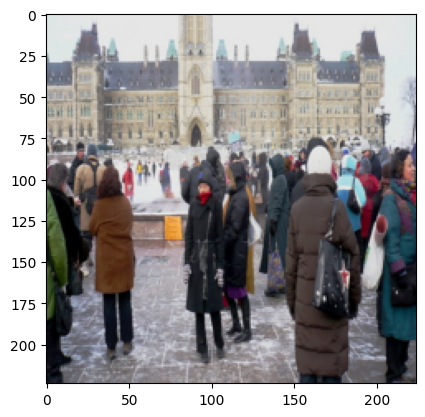

In [13]:
display_image(Images,1)

# Preprocessing Captions

In [14]:
start = "<start>"
end = "<end>"
unk = "<unk>"

In [15]:
def preprocess_text(text):
  """
  remove the digits, punctuations and change all the punctuations and all words to lower case
  this is done to make all captions contain <start>, <end>, and words in lower case
  """
  text = re.sub(r'\d+', '', text)
  text = " ".join([i.strip(string.punctuation).lower() for i in text.split()])
  text = " ".join([i for i in text.split() if len(i) > 1])
  text = text.replace('\s+', ' ').replace('\n','')
  return text


In [16]:
def preprocess_caption(output_dir):
  captions = open(output_dir, 'r').read().strip().split('\n')
  caption_dict = {}
  for row in captions[1:]:
      img_id, caption = row.split(',')[0],row.split(',')[1]
      caption = '<start> ' + preprocess_text(caption.strip()) + ' <end>'
      if img_id in caption_dict:
          caption_dict[img_id].append(caption)
      else:
          caption_dict[img_id] = [caption]

  return caption_dict

In [17]:
def tokenise_captions(captions_set):
  int_to_word = {}
  word_to_int = {}
  total_words = []
  for captions in captions_set:
    for caption in captions:
      total_words += list(filter(None,caption.split(" ")))
  unique_words = list(set(total_words))
  word_to_int = dict([(words,index+3) for index,words in enumerate(unique_words)])
  int_to_word = dict([(index+3,words) for index,words in enumerate(unique_words)])
  word_to_int[start] = 0
  word_to_int[end] = 1
  word_to_int[unk] = 2
  int_to_word[0] = start
  int_to_word[1] = end
  int_to_word[2] = unk
  return int_to_word,word_to_int

In [18]:
def encoding_captions(int_to_word, word_to_int,captions_set):
  encoded_captions = []
  for index,captions in enumerate(captions_set):
    for ind,caption in enumerate(captions):
      seq = []
      text = list(filter(None,caption.split(" ")))
      for word in text:
        if word in word_to_int.keys():
          seq.append(word_to_int[word])
        else:
          seq.append(word_to_int["<unk>"])
      encoded_captions.append((torch.tensor(seq)))
  return encoded_captions

In [19]:
caption_dict = preprocess_caption(output_file)

# Train-Validation split

In [20]:
train_split = int(0.8*len(list_of_files))
val_split = (len(list_of_files) - train_split)

train_files = list_of_files[:train_split]
validation_files = list_of_files[train_split:]


train_images = Images[:train_split,:,:,:]
validation_images = Images[train_split:,:,:,:]


In [21]:
train_captions = [caption_dict[file] for file in train_files]
vocab = tokenise_captions(train_captions)
encoded_train_captions = encoding_captions(vocab[0],vocab[1],train_captions)

In [22]:
val_captions = [caption_dict[file] for file in validation_files]
encoded_val_captions = encoding_captions(vocab[0],vocab[1],val_captions)

['<start> two men are wrestling in competition <end>', '<start> two men are wrestling while other people are watching <end>', '<start> two men wrestle on the floor in front of an group of young men <end>', '<start> two men wrestling at match <end>', '<start> two young men competing in wrestling tournament <end>']


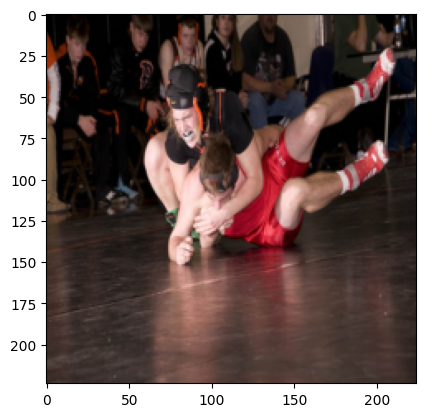

In [23]:
print(train_captions[0])
display_image(train_images,0)

In [24]:
print(train_images.shape)
print(len(vocab[0]))
print(len(train_files))
print((len(train_captions)))

torch.Size([6472, 3, 224, 224])
7804
6472
6472


# Captions Dataset

In [25]:
class CaptionDataset(Dataset):
  def __init__(self,images,encoded_captions,split,captions_per_images):
    self.images = images
    self.captions = encoded_captions
    self.captions_per_images = captions_per_images
    self.split = split # "train","val" or "test"
    self.dataset_size = len(encoded_captions)

  def __len__(self):
    return self.dataset_size

  def get_train_indices(self):
    indices = []
    randomised_captions = np.random.choice(list(range(5)),len(self.images),replace = True)
    indices = randomised_captions + np.array(list(range(len(self.images))))*5
    return list(indices)

  def __getitem__(self,index):
    # print("index:",index//self.captions_per_images)
    img = self.images[(index//self.captions_per_images),:,:,:]
    caption = self.captions[index]
    # print(type(caption))
    caplen = len(caption)
    if self.split == "train":
      return img,caption,caplen
    else :
      return img,self.captions[(index // self.captions_per_images)*self.captions_per_images:((index // self.captions_per_images) + 1)*self.captions_per_images-1]


In [26]:
train_dataset = CaptionDataset(train_images,encoded_train_captions,"train",5)
train_loader = DataLoader(train_dataset,shuffle = True)

In [27]:
validation_captions = []
for caption_set in val_captions:
  for captions in caption_set:
    validation_captions.append(captions)
val_dataset = CaptionDataset(validation_images,validation_captions,"val",5)
val_loader = DataLoader(val_dataset)

# CNN encoder part of the model

In [28]:
class CNN_model_1(nn.Module):
    #vgg 19
    def __init__(self, embed_size):
        super(CNN_model_1, self).__init__()
        vgg = models.vgg19(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad_(False)

        modules = list(vgg.children())[:-1]
        self.vgg = nn.Sequential(*modules)
        self.embed = nn.Linear(25088, embed_size)
        self.embed.weight.data.normal_(0.0, 0.02)
        self.embed.bias.data.fill_(0)

    def forward(self, images):
        features = self.vgg(images)
        features = features.reshape(features.size(0), -1)
        return self.embed(features)


In [29]:
from torchvision.models.resnet import resnet152
class CNN_model_2(nn.Module):
  # ResNet model
  def __init__(self,embed_size):
    super(CNN_model_2,self).__init__()
    resnet = models.resnet152(pretrained = True)
    for param in resnet.parameters():
      param.requires_grad_(False)
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.linear = nn.Linear(resnet.fc.in_features,embed_size)
    self.linear.weight.data.normal_(0.0, 0.02)
    self.linear.bias.data.fill_(0)

  def forward(self, images):
    features = self.resnet(images)
    # print(features.shape)
    features = features.reshape(features.size(0), -1)
    # print(features.shape)
    return self.linear(features)

# LSTM and Transformer part of the decoder

In [30]:
class DecoderNet(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(DecoderNet, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return weighted_encoding, alpha

In [31]:
import torch
import torch.nn as nn

class LSTM_model_2(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, net_dim, n_layers=1):
        super(LSTM_model_2, self).__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.net_dim = net_dim
        self.n_layers = n_layers
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.net = DecoderNet(hidden_dim, hidden_dim, net_dim)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        captions = captions[:, :-1]
        embeddings = self.embeddings(captions)
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        hidden = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)
        cell = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)
        lstm_out, _ = self.lstm(inputs, (hidden, cell))
        encoding, _ = self.net(lstm_out, features.unsqueeze(1))
        output = self.linear(encoding)

        return output

    def sample(self, features, max_len=40):
        inputs = features
        sampled_captions = []
        hidden = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)
        cell = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)

        for _ in range(max_len):
            lstm_out, (hidden, cell) = self.lstm(inputs, (hidden, cell))
            attended_encoding, _ = self.net(lstm_out, features.unsqueeze(1))
            output = self.linear(attended_encoding)
            output = output.squeeze(1).squeeze(1)
            predicted_indices = output.max(dim = 1)[1]
            sampled_captions.append(predicted_indices.item())
            inputs = self.embeddings(predicted_indices.unsqueeze(1))

        return sampled_captions


# Integrating the 2 parts of the model

In [32]:
class Model(nn.Module):
  def __init__(self,encoder,decoder,embed_size,hidden_size,vocab_size):
    """
    takes input for all the classes and creates the model
    """
    super(Model,self).__init__()
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,images,captions):
    features = self.encoder(images)
    outputs = self.decoder(features,captions)
    return features,outputs

  def evaluate_and_sample(self,image):
    features = self.encoder(image).unsqueeze(1)
    prediction = self.decoder.sample(features)
    return prediction


In [33]:
def generate_captions(model,image):
  model.eval()
  predicted_captions = model.evaluate_and_sample(image)
  sentence = ""
  for idx in predicted_captions:
    word = vocab[0][idx]
    if word != "<end>" and word != '<start>':
      sentence += vocab[0][idx] + " "
    elif word == '<end>':
      break
  return sentence

In [34]:
def validate(model):
  actual_captions = []
  generated_captions = []
  total_meteor_score = 0
  for data in tqdm(val_loader):
    image, caption_set = data
    # print(image,caption_set)
    actual_captions.append([caption[0].split() for caption in caption_set])
    generated_captions.append(generate_captions(model,image).split())
    total_meteor_score += round(meteor_score(actual_captions[-1],generated_captions[-1]),4)
  bleu1 = corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))
  bleu2 = corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
  bleu3 = corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))
  bleu4 = corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))
  # bleu = (bleu1*bleu2*bleu3*bleu4)**0.25
  total_meteor_score /= len(generated_captions)
  print(f'BLEU-1: {bleu1}')
  print(f'BLEU-2: {bleu2}')
  print(f'BLEU-3: {bleu3}')
  print(f'BLEU-4: {bleu4}')
  # print(f'BLEU:{(bleu1*bleu2*bleu3*bleu4)**0.25}')
  print(f"meteor-score:{total_meteor_score}")
  return total_meteor_score

In [35]:
def train(model,lossfn,optimizer,train_loader,validation_loader = None,num_epochs = 30):
      model.train()
      best_checkpoint_model,best_bleu = None,0
      for epoch in range(1, num_epochs+1):
            model.train()
            average_loss = 0
            count = 0
            average_perp = 0
            indices = train_loader.dataset.get_train_indices()
            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            for (img,cap,caplen) in tqdm(train_loader):
                img = img.to(device)
                cap = cap.to(device)
                model.zero_grad()
                features,outputs = model(img,cap)
                loss = lossfn(outputs.view(-1, model.vocab_size), cap.view(-1))
                loss.backward()
                optimizer.step()
                count += 1
                average_loss += loss.item()
            average_loss = average_loss/count
            average_perp = np.exp(average_loss)
            print('Epoch [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,average_loss, average_perp))
            bleu = validate(model)
            if bleu > best_bleu:
              print("checkpointing best model")
              best_checkpoint_model = copy.copy(model)
              best_bleu = bleu
      return model,best_checkpoint_model

# Calling Functions

In [36]:
learning_rate = 0.0001
num_epochs = 10
embed_size=512
hidden_size=512
net_size = 512
vocab_size=len(vocab[0])
n_layers=2

In [37]:
decoder = LSTM_model_2(embed_size, hidden_size, vocab_size, net_size, n_layers)
encoder = CNN_model_1(embed_size=embed_size)
model = Model(encoder,decoder,embed_size,hidden_size,vocab_size)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.5MB/s]


In [38]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

Val_dataset consist of 1619 images each with 5 captions, making 8095 captions. and the len of the caption_dataset is defined to be number of captions so, it shows up as 8095 but runs for 1619 images.

Whereas in train, we have restricted the indices so that we run on each image once, so it runs for 6472 images

In [40]:
final_model,best_checkpoint_model = train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs)

100%|██████████| 6472/6472 [02:18<00:00, 46.60it/s]


Epoch [1/10], Loss: 4.4935, Perplexity: 89.4350


100%|██████████| 8095/8095 [06:03<00:00, 22.27it/s]


BLEU-1: 0.36706611546571866
BLEU-2: 0.17840692435336505
BLEU-3: 0.08443102820700882
BLEU-4: 0.040370675135717064
meteor-score:0.17417980234712743
checkpointing best model


100%|██████████| 6472/6472 [02:16<00:00, 47.39it/s]


Epoch [2/10], Loss: 3.8599, Perplexity: 47.4610


100%|██████████| 8095/8095 [06:17<00:00, 21.43it/s]


BLEU-1: 0.34900186700811353
BLEU-2: 0.18954769427512333
BLEU-3: 0.09903115698166222
BLEU-4: 0.054307498260478294
meteor-score:0.18292933909820874
checkpointing best model


100%|██████████| 6472/6472 [02:16<00:00, 47.54it/s]


Epoch [3/10], Loss: 3.6015, Perplexity: 36.6530


100%|██████████| 8095/8095 [06:52<00:00, 19.64it/s]


BLEU-1: 0.3182429475123012
BLEU-2: 0.1694722313586543
BLEU-3: 0.0884114317239568
BLEU-4: 0.0458178970113233
meteor-score:0.1797676961087086


100%|██████████| 6472/6472 [02:16<00:00, 47.52it/s]


Epoch [4/10], Loss: 3.4580, Perplexity: 31.7522


100%|██████████| 8095/8095 [06:00<00:00, 22.48it/s]


BLEU-1: 0.3139925812990101
BLEU-2: 0.16822233593333483
BLEU-3: 0.08862177671644184
BLEU-4: 0.04595059796564992
meteor-score:0.1757650401482392


100%|██████████| 6472/6472 [02:15<00:00, 47.76it/s]


Epoch [5/10], Loss: 3.3454, Perplexity: 28.3728


100%|██████████| 8095/8095 [06:04<00:00, 22.21it/s]


BLEU-1: 0.33888921067139005
BLEU-2: 0.1702377675124987
BLEU-3: 0.0843779986421579
BLEU-4: 0.04245964646306081
meteor-score:0.18289153798641064


100%|██████████| 6472/6472 [02:16<00:00, 47.39it/s]


Epoch [6/10], Loss: 3.2726, Perplexity: 26.3790


100%|██████████| 8095/8095 [06:06<00:00, 22.06it/s]


BLEU-1: 0.3405895676511938
BLEU-2: 0.17978882311356895
BLEU-3: 0.09569777466357986
BLEU-4: 0.050821965547772505
meteor-score:0.18739814700432217
checkpointing best model


100%|██████████| 6472/6472 [02:15<00:00, 47.69it/s]


Epoch [7/10], Loss: 3.1813, Perplexity: 24.0777


100%|██████████| 8095/8095 [05:58<00:00, 22.60it/s]


BLEU-1: 0.31360539388043074
BLEU-2: 0.1602389063828018
BLEU-3: 0.08679453717180868
BLEU-4: 0.04911844915825648
meteor-score:0.177942557134034


100%|██████████| 6472/6472 [02:15<00:00, 47.66it/s]


Epoch [8/10], Loss: 3.1259, Perplexity: 22.7793


100%|██████████| 8095/8095 [05:57<00:00, 22.63it/s]


BLEU-1: 0.36854296024259847
BLEU-2: 0.20825904527026295
BLEU-3: 0.11826001716111771
BLEU-4: 0.06613082230530462
meteor-score:0.20321303273625715
checkpointing best model


100%|██████████| 6472/6472 [02:15<00:00, 47.65it/s]


Epoch [9/10], Loss: 3.0652, Perplexity: 21.4392


100%|██████████| 8095/8095 [06:03<00:00, 22.25it/s]


BLEU-1: 0.3429147923698148
BLEU-2: 0.18396638564634293
BLEU-3: 0.09985488662781072
BLEU-4: 0.05323828282863685
meteor-score:0.19070963557751594


100%|██████████| 6472/6472 [02:15<00:00, 47.64it/s]


Epoch [10/10], Loss: 3.0029, Perplexity: 20.1448


100%|██████████| 8095/8095 [06:00<00:00, 22.46it/s]


BLEU-1: 0.3493488306110898
BLEU-2: 0.19106289094722392
BLEU-3: 0.10723976131122569
BLEU-4: 0.06017394496942934
meteor-score:0.1975431130327363


# Generating Captions

In [41]:
def generate_captions_for_random_image(model):
    index = np.random.choice(len(validation_images),1,replace = True)
    image = validation_images[index,:,:,:]
    captions = generate_captions(model,image)
    print(captions)
    T = transforms.ToPILImage()
    img = T(image.squeeze())
    plt.imshow(img)

dog jumps over hurdle 


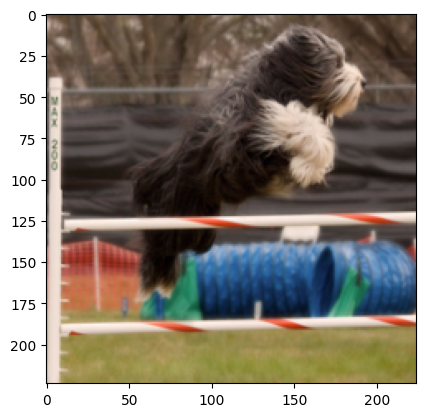

In [103]:
generate_captions_for_random_image(best_checkpoint_model)

group of people are walking through the woods 


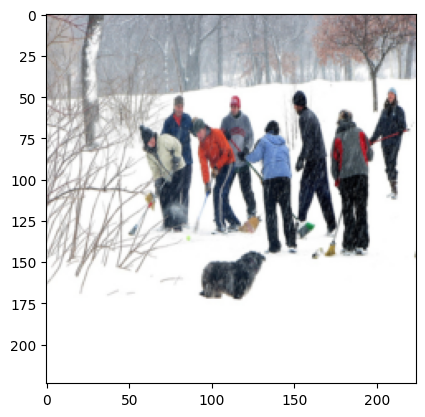

In [77]:
generate_captions_for_random_image(best_checkpoint_model)

two dogs are playing in the grass 


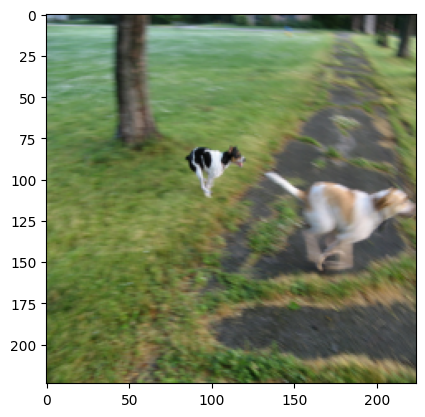

In [51]:
generate_captions_for_random_image(best_checkpoint_model)

man in black shirt and black hat 


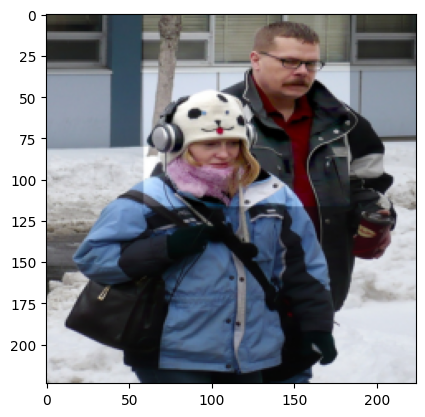

In [45]:
generate_captions_for_random_image(best_checkpoint_model)

girl in pink shirt and blue shorts is jumping into the air 


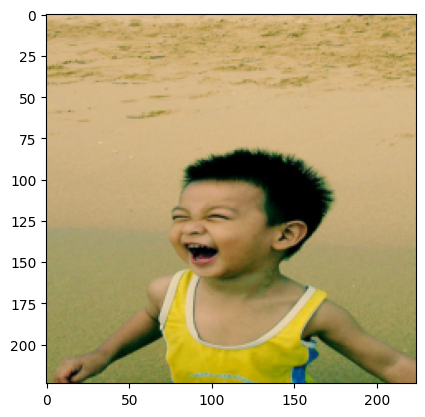

In [48]:
generate_captions_for_random_image(best_checkpoint_model)

boy in blue shirt is jumping on trampoline 


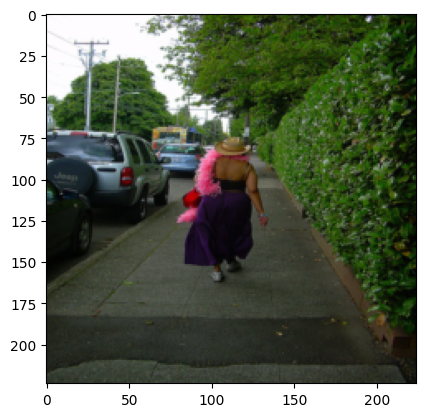

In [47]:
generate_captions_for_random_image(best_checkpoint_model)